In [447]:
import torch
import torch.nn as nn
import numpy as np
import glob
import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import torch.nn.functional as F
from collections import defaultdict
import copy
import sys
from mpl_toolkits import mplot3d
from pathlib import Path
import string
from argparse import Namespace
import collections

sys.path.append('.')
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "serif",
    'font.size':16,
    "lines.linewidth":3.0,
    "savefig.dpi":500,
    'text.latex.preamble':r'\boldmath'
})
plt.rc('axes', grid=True)

cmap=plt.cm.Spectral_r

savedir= './figs/'
if not os.path.exists(savedir):
    os.mkdir(savedir)

In [448]:
def find(array, value):
    idx= np.argwhere(np.array(array)==value)[0,0]
    return idx

def h2p(width, input_size, depth):
    return input_size*width + (depth-1) * width**2 + width
h2p = np.vectorize(h2p)

def select_runs(runs, params, constraints):
    selected_runs = []
    for irun, run in enumerate(runs):
        keep = True
        for k,v in constraints.items():
            if type(v)!=list:
                v=[v]
            if getattr(run['args'],k) not in v:
                keep = False
                break
        if keep:
            selected_runs.append(run)
    selected_params = copy.deepcopy(params)
    for con in constraints:
        selected_params[con]=[constraints[con]]
    return selected_runs, selected_params

def group_runs(runs, finished_only=True):
    runs_grouped = defaultdict(list)
    for run in runs:
        seedless_args = copy.deepcopy(run['args'])
        del(seedless_args.seed)
        del(seedless_args.name)
        if str(seedless_args) not in runs_grouped.keys(): 
            runs_grouped[str(seedless_args)].append(run) # need at least one run
        else:
            if run['finished'] or not finished_only:
                runs_grouped[str(seedless_args)].append(run)
    runs_grouped = list(runs_grouped.values())
    return runs_grouped

def sigmoid(x):
    return 1/(1+np.exp(-x))

In [671]:
#1611224878 locality
#1611413693 datasize
#1611436788 model size CIFAR100

# 1611306605 model size Imagenet
# 1611509565 model size CIFAR100
# 1611525499 datasize

# 1611792683 model size Imagenet lr
# 1612129405 ablation

runs = []
logs = []
numbers = [1611306605, 1611525499]
numbers = [-2]

for num in numbers:

    base = '/checkpoint/leventsagun/deit/'
    if num<0:
        paths = sorted(glob.glob(base+'*'), key=(lambda x : x.split('/')[-1]))
        paths=[p for p in paths if os.path.isdir(p)]
        print(paths)
        path = paths[num]
    else:
        path = base+str(num)
    path += '/'
    print(path)

    dirnames = glob.glob(path+'*')
    dirnames = [p for p in dirnames if (os.path.isdir(p) and not p.endswith('__'))]
    print('{} runs found'.format(len(dirnames)))
    fails = 0
    for dirname in dirnames:
        print(dirname)
        try : 
            run = {}
            args = torch.load(dirname+'/args.pyT', map_location=torch.device('cpu'))
            run['args'] = args
            f = open(dirname+'/log.txt', "r")
            log = [eval(line) for line in f.readlines()]
            run['logs']=log
            runs.append(run)
        except: 
            print('failed {}'.format(dirname))
            fails += 1
    print('{} fails'.format(fails))
    
latest = min([len(run['logs']) for run in runs])-1
print('latest : ',latest)
params = defaultdict(list)
for run in runs:
    for k,v in vars(run['args']).items():
        params[k].append(v)
for k in params:
    try: params[k] = sorted(list(set(params[k])))
    except: pass

['/checkpoint/leventsagun/deit/1611568264', '/checkpoint/leventsagun/deit/1611673131']
/checkpoint/leventsagun/deit/1611568264/
6 runs found
/checkpoint/leventsagun/deit/1611568264/layer_0_model_deit_tiny_patch16_224
/checkpoint/leventsagun/deit/1611568264/layer_0_model_deit_small_patch16_224
/checkpoint/leventsagun/deit/1611568264/layer_0_model_deit_base_patch16_224
/checkpoint/leventsagun/deit/1611568264/layer_10_model_deit_tiny_patch16_224
/checkpoint/leventsagun/deit/1611568264/layer_10_model_deit_small_patch16_224
/checkpoint/leventsagun/deit/1611568264/layer_10_model_deit_base_patch16_224
0 fails
latest :  2555


# Data size

3598
2506
300


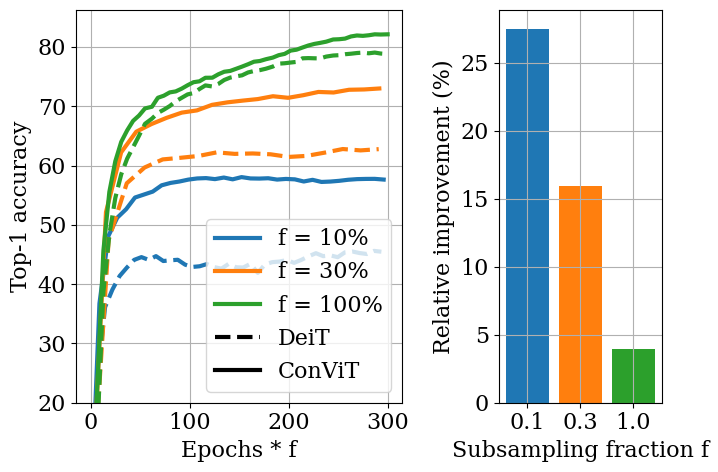

In [622]:
topk=1
max_epochs=300

fig, axarr = plt.subplots(1,2,figsize=(7,5),gridspec_kw={'width_ratios': [2, 1]})
improvements=[]
perfs = {}
for i, sr in enumerate(params['sampling_ratio'][1:]):
    selected_runs, _ = select_runs(runs, params, {'sampling_ratio':sr, 
                                                 'model':'deit_small_patch16_224'})
    latest = min([len(run['logs']) for run in selected_runs])
    print(latest)
    for run in selected_runs:
        latest_run = len(run['logs'])
        local = bool(run['args'].local_up_to_layer)
        #x = np.array(np.logspace(0,np.log10(latest-1),50).astype(int))
        x = np.linspace(0,latest_run-1,50).astype(int)
        x = x[x<max_epochs/sr]
        axarr[0].plot((x+1)*sr, [run['logs'][k]['test_acc%d'%topk] for k in x], ls='-' if local else '--', 
                color = 'C%d'%i, 
                label=('f = {0:.0f}%'.format(sr*100)) if local else '',) 
        perfs[(sr,local)] = max([run['logs'][t]['test_acc%d'%topk] for t in range(latest)])
    try: 
        improvement = (perfs[(sr,True)]-perfs[(sr,False)])/perfs[(sr,False)]*100
        improvements.append(improvement)
        axarr[1].bar(i, improvement, color='C%d'%i)
    except: 
        continue

axarr[0].plot([],[],color='k',label='DeiT', ls='--')
axarr[0].plot([],[],color='k',label='ConViT')
axarr[0].legend()
axarr[0].set_xlabel('Epochs * f')
axarr[0].set_ylabel('Top-{} accuracy'.format(topk))
#axarr[0].set_xscale('log')
axarr[0].set_ylim(bottom=20)
axarr[1].set_xticks(range(len(improvements)))
axarr[1].set_xticklabels(params['sampling_ratio'][1:])
axarr[1].grid(True,zorder=0)
axarr[1].set_xlabel('Subsampling fraction f')
axarr[1].set_ylabel('Relative improvement (%)')
axarr[1].set_ylim(bottom=0)
plt.tight_layout()
plt.savefig(savedir+'data_size.pdf')
plt.show()

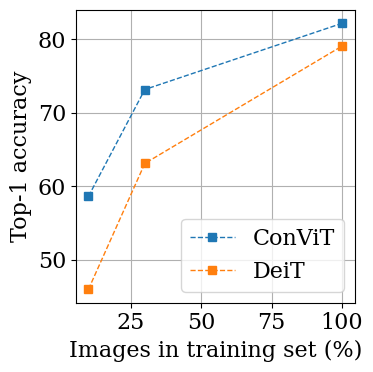

In [437]:
plt.figure(figsize=(4,4))
x = np.array(params['sampling_ratio'][1:])
plt.plot(100*x,[perfs[(sr,True)] for sr in x ],ls='--',lw=1,marker='s',label='ConViT')
plt.plot(100*x,[perfs[(sr,False)] for sr in x],ls='--',lw=1,marker='s',label='DeiT')
#plt.scatter(1,77.9,marker='s',label='ViT', color='red')
plt.legend()
plt.xlabel('Images in training set (%)')
plt.ylabel('Top-1 accuracy')
plt.tight_layout()
plt.savefig(savedir+'data_size_intro.pdf')
plt.show()

# Model size

deit_base_patch16_224 False 3000 96.93000280761719
deit_base_patch16_224 True 3000 97.66000263671874
deit_small_patch16_224 False 3000 97.31000239257813
deit_small_patch16_224 True 2556 97.75000278320313
deit_tiny_patch16_224 False 3000 97.33000249023438
deit_tiny_patch16_224 True 3000 97.44000234375


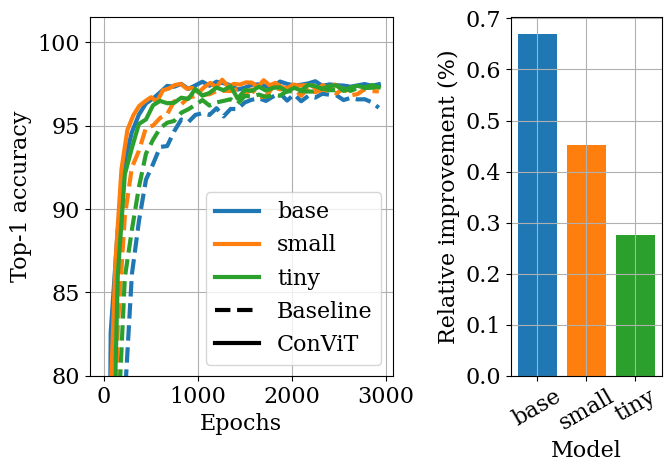

In [674]:
topk=1
max_epochs = 3000

fig, axarr = plt.subplots(1,2,figsize=(7,5),gridspec_kw={'width_ratios': [2, 1]})

improvements = []
for i, model in enumerate(params['model']):
    selected_runs, _ = select_runs(runs, params, {'model':model, 'sampling_ratio':1})
    latest = min([len(run['logs']) for run in selected_runs])
    perfs = {}
    for run in selected_runs:
        latest_run = min(len(run['logs']),max_epochs)
        local = bool(run['args'].local_up_to_layer)
        x = np.array(range(0,latest_run,latest_run//40))
        axarr[0].plot(x+1, [run['logs'][t]['test_acc%d'%topk] for t in x], ls='-' if local else '--', label=(model.split('_')[1]) if local else '', color = 'C%d'%i)
        #axarr[0].plot(x, [run['logs'][t]['train_lr'] for t in x], ls='-' if local else '--', label=(model.split('_')[1]) if local else '', color = 'C%d'%i)
        perfs[local] = max([run['logs'][t]['test_acc1'] for t in range(latest)])
        print(model,local,latest_run,max([run['logs'][t]['test_acc%d'%topk] for t in x]))
        
    improvement = (perfs[True]-perfs[False])/perfs[False]*100
    improvements.append(improvement)
    axarr[1].bar(i, improvement, color='C%d'%i)


axarr[0].plot([],[],color='k',label='Baseline', ls='--')
axarr[0].plot([],[],color='k',label='ConViT')
axarr[0].legend()
axarr[0].set_xlabel('Epochs')
axarr[0].set_ylabel('Top-{} accuracy'.format(topk))
axarr[0].set_ylim(bottom=80)
#axarr[0].set_xscale('log')
axarr[1].set_xticks(range(len(improvements)))
axarr[1].set_xticklabels([label.split('_')[1] for label in params['model']],rotation=30)
axarr[1].set_xlabel('Model')
axarr[1].set_ylabel('Relative improvement (%)')
axarr[1].set_ylim(bottom=0)
plt.tight_layout()
plt.savefig(savedir+'model_size_{}.pdf'.format(params['data_set'][0]))
plt.show()

# Grid search

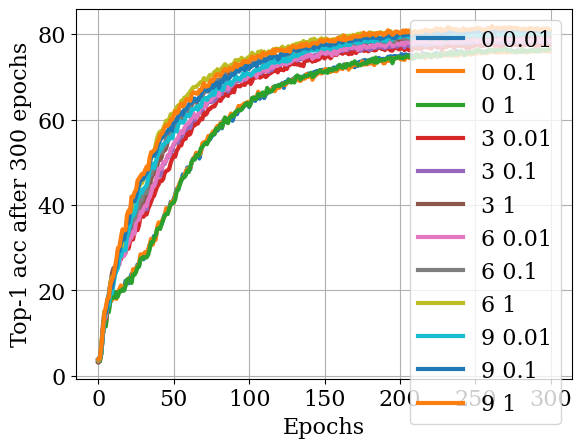

81.06000244140625


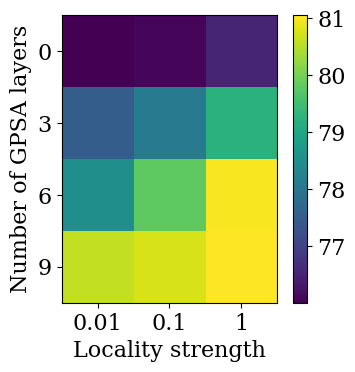

In [191]:
latest = min([len(run['logs']) for run in runs])
topk=1
key1 = 'local_up_to_layer'
key2 = 'locality_strength'

plt.figure()
grid = np.zeros((len(params[key1]),len(params[key2])))
for run in runs:
    args = run['args']
    i,j = find(getattr(args,key1), params[key1]), find(getattr(args,key2), params[key2])
    grid[i,j] = run['logs'][latest-1]['test_acc%d'%topk]
    plt.plot(range(latest), [run['logs'][k]['test_acc%d'%topk] for k in range(latest)], label='{} {}'.format(getattr(args,key1), getattr(args, key2)))    
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Top-{} acc after {} epochs'.format(topk,latest))
plt.show()

print(np.max(grid))

plt.figure(figsize=(4,4))
plt.imshow(grid)
plt.gca().set_xticks(range(len(params[key2])))
plt.gca().set_yticks(range(len(params[key1])))
plt.gca().set_xticklabels(params[key2])
plt.gca().set_yticklabels(params[key1])
plt.ylabel('Number of GPSA layers')
plt.xlabel('Locality strength')
plt.colorbar()
plt.tight_layout()
plt.grid(False)
plt.savefig(savedir+'strength.pdf')
plt.show()

# Varying number of local layers

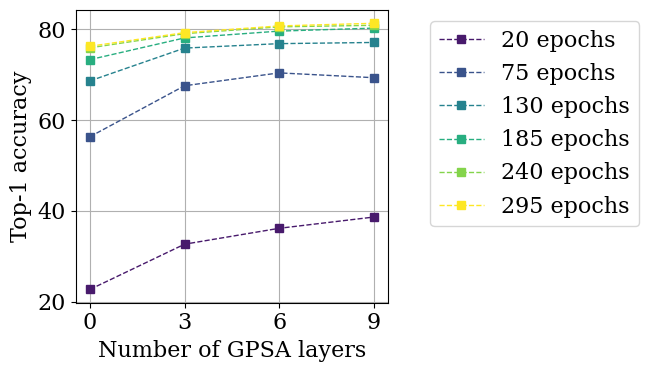

In [200]:
topk=1
cons = {'locality_strength':1,
       }
selected_runs, _ = select_runs(runs, params, cons)

plt.figure(figsize=(7,4))
times = range(20,latest-1,(latest-20)//5-1)
x, y = [], defaultdict(list)
for run in selected_runs:
    x.append(run['args'].local_up_to_layer)
    for t in times:
        y[t].append(run['logs'][t]['test_acc{}'.format(topk)])
#plt.annotate('Baseline',(min(x)+.1,min(y)+.1), color='red')
    
for t in times:
    plt.plot(x,y[t], marker='s', ls='--', lw=1, label='{} epochs'.format(t), color=plt.cm.viridis(t/times[-1]))
plt.legend(bbox_to_anchor=(1.1,1))
plt.xticks(params['local_up_to_layer'])
plt.xlabel('Number of GPSA layers')
plt.ylabel('Top-{} accuracy'.format(topk,latest))
plt.tight_layout()
plt.savefig(savedir+'acc_vs_locality.pdf')
plt.show()

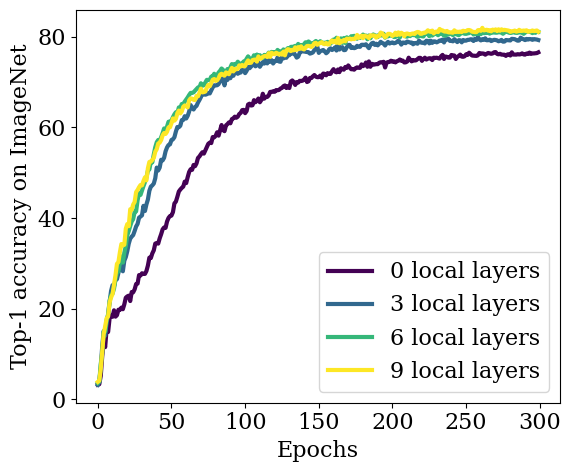

In [369]:
topk=1
cons = {'locality_strength':1,
       }
selected_runs, _ = select_runs(runs, params, cons)

plt.figure(figsize=(6,5))
for run in selected_runs:
    n_local = run['args'].local_up_to_layer
    latest = len(run['logs'])
    plt.plot(range(latest), [run['logs'][k]['test_acc%d'%topk] for k in range(latest)], 
             label='{} local layers'.format(n_local), color=plt.cm.viridis(n_local/max([run['args'].local_up_to_layer for run in selected_runs])))
    #plt.plot(range(latest), [run['test'][k]['loss'] for k in range(latest)], color=cmap(n_local/12), label='{} local layers'.format(n_local))
    #plt.plot(range(latest), [run['train'][k]['loss'] for k in range(latest)], ls='--', color=cmap(n_local/12))
    
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Top-{} accuracy on ImageNet'.format(topk))
plt.tight_layout()
plt.savefig(savedir+'acc_vs_locality_dynamics.pdf')
plt.show()

# Attention maps

In [641]:
from main import create_model, build_dataset
%load_ext autoreload
%autoreload 2

def highlight_cell(x,y, ax=None, size=1, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), size, size, fill=False, color='red', lw=3, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

def plot_attention(model,x,layers=[0], save=False, init=False, title=None):
    
    x = model.patch_embed(x)
    
    num_patches = model.num_patches
    img_size = int(num_patches**.5)
    num_heads = model.blocks[0].attn.num_heads
    embed_dim = model.embed_dim

    num_layers = len(layers)
    fig, axarr = plt.subplots(num_layers, num_heads, figsize=(2*num_heads,2*num_layers), constrained_layout=True)
    if num_layers==1:
        axarr = [axarr]
    dists, alphas = {},{}
    for i, l in enumerate(layers):
        dists[l], attn_map = model.blocks[l].attn.get_attention_map(x, return_map=True)
        num_heads = len(attn_map)
        for head in range(num_heads):
            head_map = attn_map[head,num_patches//2+img_size//2].detach().cpu().resize(img_size,img_size)
            im = axarr[i][head].matshow(np.log10(head_map), cmap=plt.cm.viridis)
            #plt.colorbar(im, ax = axarr[i][head])
            if l < model.local_up_to_layer:
                try:
                    alpha = model.blocks[l].attn.alpha.squeeze()[head].item()
                except:
                    alpha = model.blocks[l].attn.alpha.squeeze()[head].item()
                if not init: axarr[i][head].annotate(r'$\sigma(\lambda)={0:.2f}$'.format(sigmoid(alpha)), xy=(.3,1.5), fontsize=20, color=plt.cm.Reds(sigmoid(alpha)))
            #print(head_map)
        for ax in axarr[i]:
            ax.set_xticks([]) 
            ax.set_yticks([]) 
            highlight_cell(img_size//2, img_size//2,ax)
                
    cols = [r'Head {}'.format(col+1) for col in range(num_heads)]
    rows = ['Layer {}'.format(row+1) for row in layers]
    for ax, col in zip(axarr[0], cols):
        ax.set_title(col, fontsize=15, pad=10)
    if not init:
        for ax, row in zip(axarr[:,0], rows):
            ax.set_ylabel(row, fontsize=15, labelpad=10)
    
    if save:
        plt.savefig(savedir+title)
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/private/home/sdascoli/.conda/envs/bert/lib/python3.7/site-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


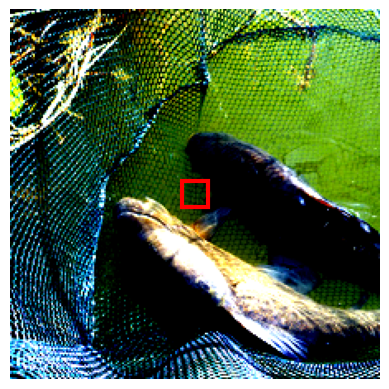

/private/home/sdascoli/.conda/envs/bert/lib/python3.7/site-packages/torch/tensor.py:454: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


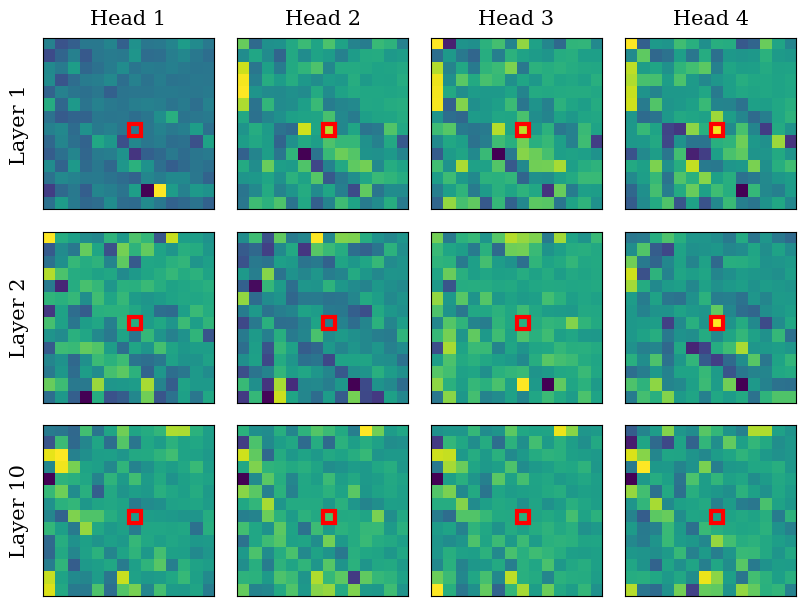

In [34]:
cons = {'model': 'deit_tiny_patch16_224',
        'local_up_to_layer' : 0,
        'sampling_ratio' : 1
       }
save = False
selected_runs, _ = select_runs(runs, params, cons)
run = selected_runs[0]
args = run['args']
model = create_model(args.model, num_classes=args.nb_classes,
                    local_up_to_layer=args.local_up_to_layer, 
                    locality_dim=args.locality_dim)
model.to('cuda')

args = run['args']
idx = 0
dataset, _ = build_dataset(is_train=False, args=args)
x = torch.stack([dataset[idx+i][0] for i in range(1)])
plt.figure()
plt.imshow(x[0].transpose(0,1).transpose(1,2))
plt.grid(False)
plt.axis(False)
highlight_cell(224//2-8, 224//2-8, size=16, ax=plt.gca())
if save : plt.savefig(savedir+'photo_{}.pdf'.format(idx))
plt.show()
x = x.cuda()

title = 'attention_map_final_{}_{}_{}_{}.pdf'.format(idx, ('local' if model.local_up_to_layer else 'nonlocal'),args.model.split('_')[1],args.data_set)
state_dict = torch.load(str(args.output_dir/'checkpoint.pth'))["model"]
model.load_state_dict(state_dict)
plot_attention(model, x, layers=[0,1,9], save=save, title=title)

/private/home/sdascoli/.conda/envs/bert/lib/python3.7/site-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/private/home/sdascoli/.conda/envs/bert/lib/python3.7/site-packages/torch/tensor.py:454: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


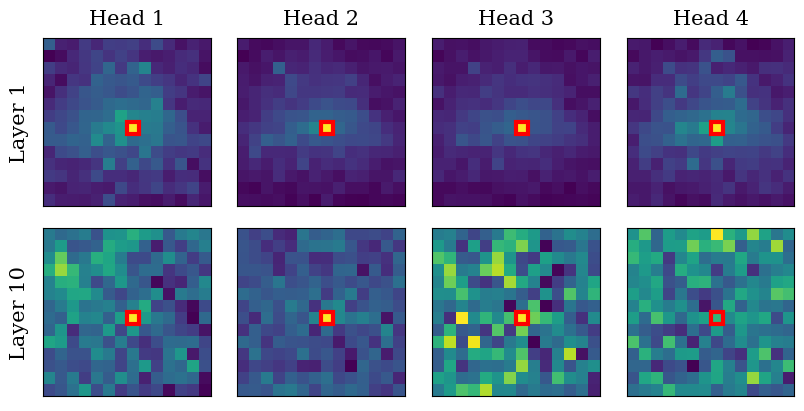

In [643]:
cons = {'model': 'deit_tiny_patch16_224',
        'local_up_to_layer' : 0,
        'sampling_ratio' : 1.0
       }
selected_runs, _ = select_runs(runs, params, cons)
run = selected_runs[0]
args = run['args']
model = create_model(args.model, num_classes=args.nb_classes,
                    local_up_to_layer=args.local_up_to_layer, 
                    locality_dim=args.locality_dim)
model.to('cuda')

dataset, _ = build_dataset(is_train=False, args=args)
x = torch.stack([dataset[i][0] for i in range(100)])
x = x.cuda()

title = 'attention_map_final_averaged_{}_{}_{}.pdf'.format(('local' if model.local_up_to_layer else 'nonlocal'),args.model.split('_')[1],args.data_set)
state_dict = torch.load(str(args.output_dir/'checkpoint.pth'))["model"]
model.load_state_dict(state_dict)
plot_attention(model, x, layers=[0,9], init=False, save=True, title=title)

/private/home/sdascoli/.conda/envs/bert/lib/python3.7/site-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/private/home/sdascoli/.conda/envs/bert/lib/python3.7/site-packages/torch/tensor.py:454: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


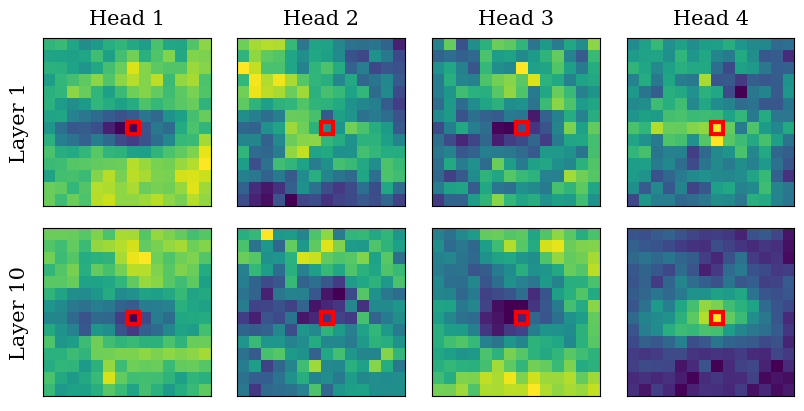

In [644]:
from main import create_model, build_dataset
strength=5
local_up_to=0
model = create_model('deit_tiny_patch16_224', local_up_to_layer=local_up_to, locality_strength=strength, locality_dim=10)
for l in range(local_up_to):
    model.blocks[l].attn.alpha.data.fill_(0)
model.to('cuda')
args = run['args']
dataset, _ = build_dataset(is_train=False, args=args)

averaged = True
if averaged:
    x = torch.stack([dataset[i][0] for i in range(100)])
else:
    x = torch.stack([dataset[701+i][0] for i in range(1)])
x = x.cuda()

title = 'attention_map_init{}_{}{}.pdf'.format(('_averaged' if averaged else ''),
                                               ('local' if model.local_up_to_layer else 'nonlocal'),
                                               ('_strength_{}' if model.local_up_to_layer else ''))
plot_attention(model, x, layers=[0,9], init=False, save=True, title=title)

# Nonlocality

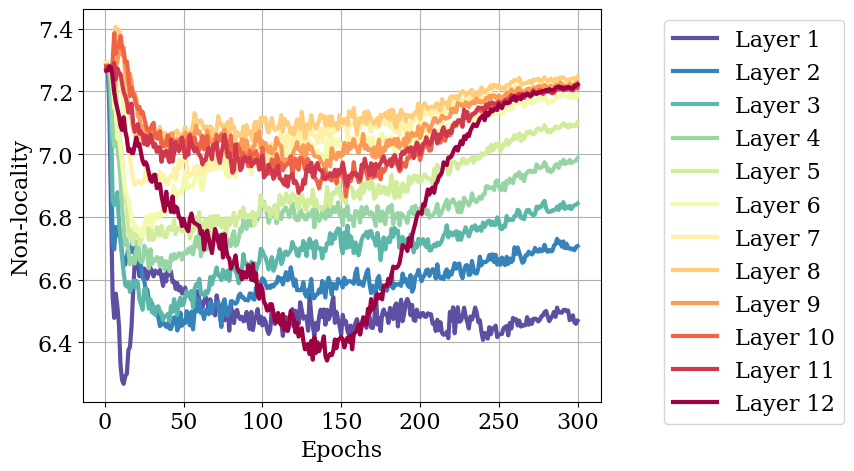

In [538]:
topk=1

cons = {'model': 'deit_base_patch16_224',
        'local_up_to_layer' : 0,
        'sampling_ratio':1,
       }
selected_runs, _ = select_runs(runs, params, cons)
run = selected_runs[0]
latest = len(run['logs'])
args = run['args']

plt.figure(figsize=(9,5))
for l in range(12):
    x = np.array(range(0,latest,1))
    args = run['args']
    plt.plot(x+1, [run['logs'][k]['attn_distance_%d'%l] for k in x], color=cmap(l/11), label=('Layer %d'%(l+1) if not l%1 else ""))

legend = plt.legend(bbox_to_anchor=(1.1,1))
plt.xlabel('Epochs')
plt.ylabel('Non-locality'.format(topk,latest))
#if not args.local_up_to_layer: plt.ylim(bottom=5.5,top=7.5)
plt.tight_layout()
plt.savefig(savedir+'nonlocality_{}_{}_{}.pdf'.format('local' if args.local_up_to_layer else 'nonlocal', args.model.split('_')[1],args.data_set))
plt.show()

# Gating parameters

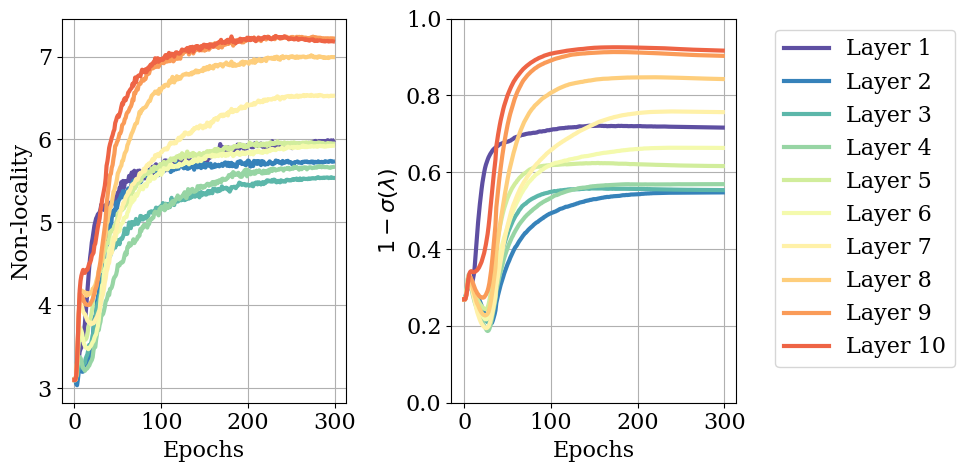

In [523]:
topk=1

cons = {'model': 'deit_base_patch16_224',
        'local_up_to_layer' : 10,
        'sampling_ratio' : 1
       }
selected_runs, _ = select_runs(runs, params, cons)
run = selected_runs[0]
latest = len(run['logs'])
args = run['args']

fig, axarr = plt.subplots(1,2,figsize=(10,5))

for l in range(args.local_up_to_layer):
    axarr[1].plot(range(latest), [1-sigmoid(run['logs'][k]['locality_param_%d'%l]) for k in range(latest)], color=cmap(l/11), 
             label=('Layer %d'%(l+1) if not l%1 else ""))
    axarr[0].plot(range(latest), [run['logs'][k]['attn_distance_%d'%l] for k in range(latest)], color=cmap(l/11), 
             label=('Layer %d'%(l+1) if not l%1 else ""))

axarr[1].legend(ncol=1, bbox_to_anchor=(1.1,1.))
for ax in axarr:
    ax.set_xlabel('Epochs')
    #ax.set_xscale('log')
axarr[0].set_ylabel('Non-locality')
axarr[1].set_ylabel('$1-\sigma(\lambda)$')
axarr[1].set_ylim(0,1)
plt.tight_layout()
plt.savefig(savedir+'gating_parameter_{}_{}.pdf'.format(args.model.split('_')[1],args.data_set))
plt.show()

# Ablation

81.3920025415039
73.73800211669922
82.15000244384765
78.57200236572265
81.56800233886719
75.44400242919922
81.96800232421874
77.96400228759765
79.08600248291016


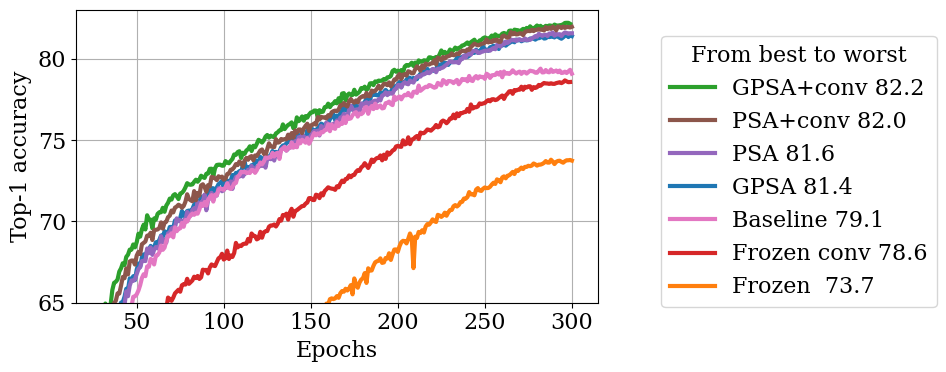

In [608]:
latest = min([len(run['logs']) for run in runs])
topk=1

fig, ax = plt.subplots(1,figsize=(10,4))
scores = {}
for run in runs:
    args = run['args']
    latest_run = len(run['logs'])
    print(run['logs'][latest_run-1]['test_acc1'])
    x = np.array(range(0, latest_run,1))
    y = [run['logs'][k]['test_acc%d'%topk] for k in x]
    if not args.local_up_to_layer:
        label = 'Baseline'
    else:
        if args.freeze_local_init:
            if args.freeze_mixing_param: continue            
            label='Frozen ' + ('conv' if args.use_local_init else '')
        else:
#            label='GPSA {} {}'.format('conv' if args.use_local_init else '',
#                                    'frozen gate' if args.freeze_mixing_param else '')
            label='{}{}'.format('PSA' if args.freeze_mixing_param else 'GPSA',
                                 '+conv' if args.use_local_init else '')
    label += ' {0:.1f}'.format(y[-1])
    scores[label] = y[-1]
    ax.plot(x+1, y, label=label)  
    
    #left, bottom, width, height = [0.25, 0.1, 0.25, 0.4]
    #ax2 = fig.add_axes([left, bottom, width, height])
    #ax2.plot(x+1, y)
    
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: scores[t[0]], reverse=True))
ax.legend(handles, labels, bbox_to_anchor=(1.1,.95), title='From best to worst')

ax.set_xlabel('Epochs')
ax.set_ylabel('Top-{} accuracy'.format(topk,latest))
ax.set_xlim(left=15)
ax.set_ylim(bottom=65, top=83)
#ax2.set_xlim(left=0, right=15)
#ax2.set_ylim(bottom=0, top=60)

plt.tight_layout()
plt.savefig(savedir+'ablation.pdf')
plt.show()

# Distillation

In [ ]:
# 35343650 distillation nonlocal
# 35343651 distillation local

from lecture import lecture

runs = []
logs = []
numbers = [35343650,35343651] # Hard
numbers = [35638718,35638716] # Soft
#numbers = [34784338, 34780243] # Comparison

for num in numbers:

    base = "/checkpoint/htouvron/Classification_transformers/"
    path = base + str(num) + '/'
    print(path)
    run = {}
    false=False
    true=True
    null=None
    with open(path+"commandline_args.txt", "r") as file:
        contents = file.read()
        args = eval(contents)
    checkpoint_paths = glob.glob(path+'checkpoint_*')
    times = [int(checkpoint_path.split('/')[-1].lstrip('checkpoint_').rstrip('.pth')) for checkpoint_path in checkpoint_paths]
    args = Namespace(**args)
    print(times)
    print(args.model)
    args.output_dir=path
    acc1, acc5 = lecture(path+str(num)+'_0_log.out',plots=True)
    run['acc1']=acc1
    run['acc5']=acc5
    run['args']=args
    run['checkpoints']=checkpoint_paths
    run['times']=times
    runs.append(run)
    
print(runs[0]['args'].data_set)
params = defaultdict(list)
for run in runs:
    for k,v in vars(run['args']).items():
        params[k].append(v)
for k in params:
    params[k] = sorted(list(set(params[k])))

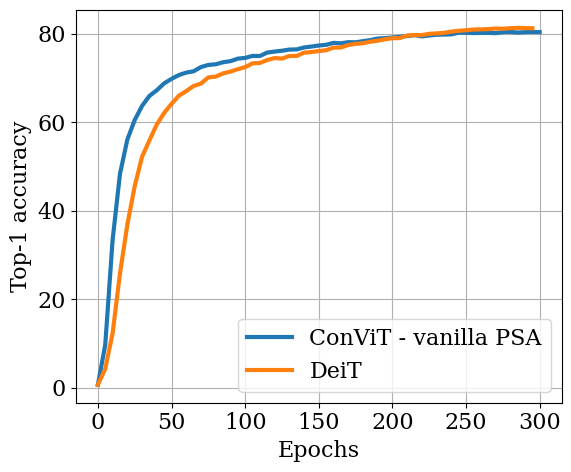

In [501]:
plt.figure(figsize=(6,5))
for i, label in enumerate(['ConViT - vanilla PSA','DeiT']):
    run = runs[i]
    acc1 = run['acc1']
    x = np.array(range(len(acc1)))
    plt.plot(x*5, acc1, label=label)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Top-1 accuracy')
plt.tight_layout()
plt.savefig(savedir+'vanilla-PSA.pdf')
plt.show()

In [593]:
nonlocalities = {'local':defaultdict(list), 'nonlocal':defaultdict(list)}
for i, local_up_to in enumerate([0,10]):
    label = 'local' if local_up_to else 'nonlocal'
    plt.figure()
    model = create_model('deit_small_patch16_224', local_up_to_layer=local_up_to, locality_dim=10)
    model.to('cuda')
    gatings = defaultdict(list)
    run = runs[i]
    times = run['times'][::]
    for t in times:
        print(t, end=' ')
        state_dict_old = torch.load(runs[i]['args'].output_dir+'checkpoint_{}.pth'.format(t))['model']
        state_dict = collections.OrderedDict()
        for k in state_dict_old:
            state_dict[k.lstrip('module.')] = state_dict_old[k]
        model.load_state_dict(state_dict)
        
        x = torch.stack([dataset[i][0] for i in range(100)])
        x = x.to('cuda')
        x = model.patch_embed(x)

        for l in range(12):
            if l<local_up_to: 
                gating = sigmoid(model.blocks[l].attn.alpha.mean().item())
                gatings[l].append(gating)
            nonlocality = model.blocks[l].attn.get_attention_map(x, return_map=False)
            nonlocalities[label][l].append(nonlocality)

125 130 135 140 145 150 155 160 165 170 175 180 185 190 100 105 110 115 120 125 130 135 140 145 

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105]


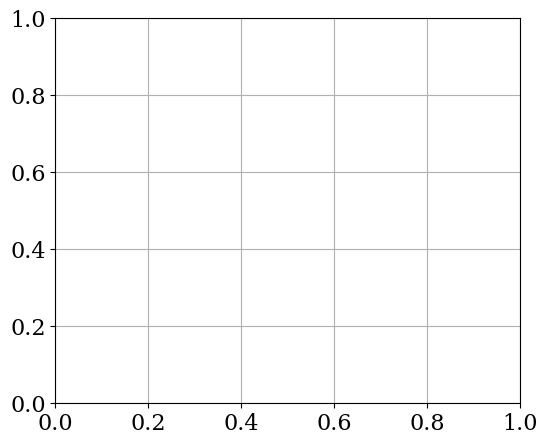

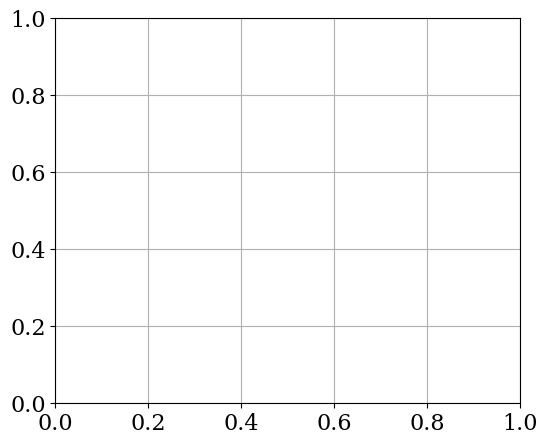

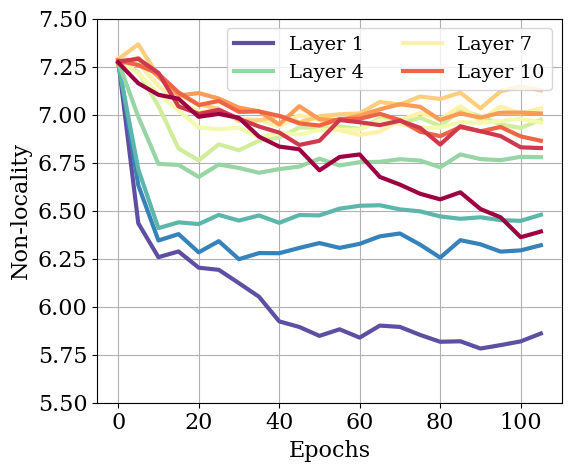

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]


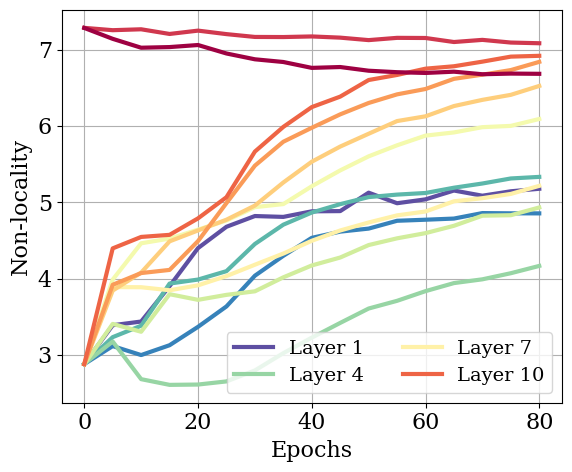

In [467]:
for i,label in enumerate(['nonlocal', 'local']):
    times = runs[i]['times'][::]
    print(times)
    plt.figure(figsize=(6,5))
    for l in range(12):
        plt.plot(times, nonlocalities[label][l],color=plt.cm.Spectral_r(l/11), label=('Layer %d'%(l+1) if not l%3 else ""))

    plt.legend(ncol=2, fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Non-locality')
    if label=='nonlocal':plt.ylim(bottom=5.5,top=7.5)
    plt.tight_layout()
    plt.savefig(savedir+'nonlocality_dist_{}_{}_{}.pdf'.format(label, args.model.split('_')[1],args.data_set))
    plt.show()

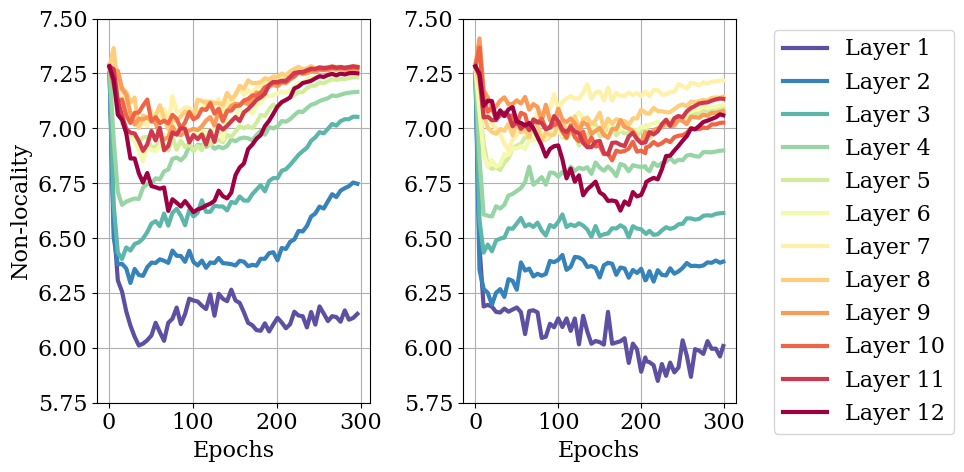

In [189]:
topk=1

cons = {'model': 'deit_small_patch16_224',
        'local_up_to_layer' : 0,
        'sampling_ratio':1,
       }
selected_runs, _ = select_runs(runs, params, cons)
run = selected_runs[0]
latest = len(run['logs'])
args = run['args']

fig, axarr = plt.subplots(1,2,figsize=(10,5))
for l in range(12):
    x = np.array(range(0,latest,5))
    args = run['args']
    axarr[0].plot(x+1, [run['logs'][k]['attn_distance_%d'%l] for k in x], color=cmap(l/11))
    axarr[1].plot(times, nonlocalities[label][l],color=plt.cm.Spectral_r(l/11), label=('Layer %d'%(l+1) if not l%1 else ""))

axarr[1].legend(ncol=1, bbox_to_anchor=(1.1,1.))
axarr[0].set_ylabel('Non-locality')
for ax in axarr:
    ax.set_xlabel('Epochs')
    ax.set_ylim(bottom=5.75,top=7.5)
plt.tight_layout()
plt.savefig(savedir+'nonlocality_compared_{}_{}_{}.pdf'.format(label, args.model.split('_')[1],args.data_set))
plt.show()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

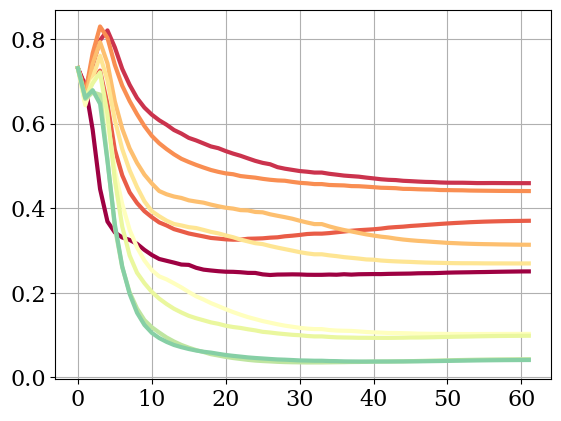

In [28]:
plt.figure()
for l in range(12):
    plt.plot(gatings[l],color=plt.cm.Spectral(l/12))
plt.show()

/private/home/sdascoli/.conda/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


<Figure size 640x480 with 0 Axes>

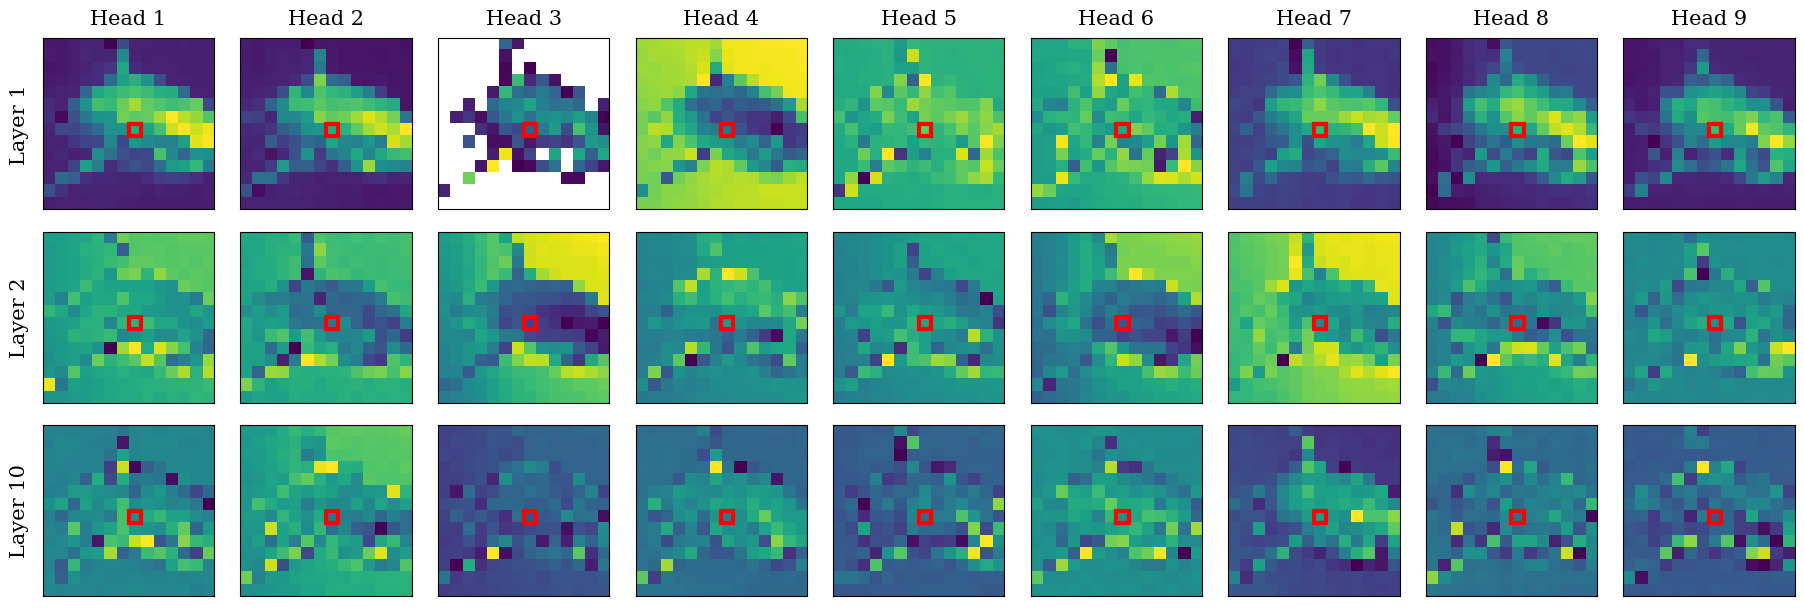

/private/home/sdascoli/.conda/envs/bert/lib/python3.7/site-packages/torch/tensor.py:454: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/private/home/sdascoli/.conda/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


<Figure size 640x480 with 0 Axes>

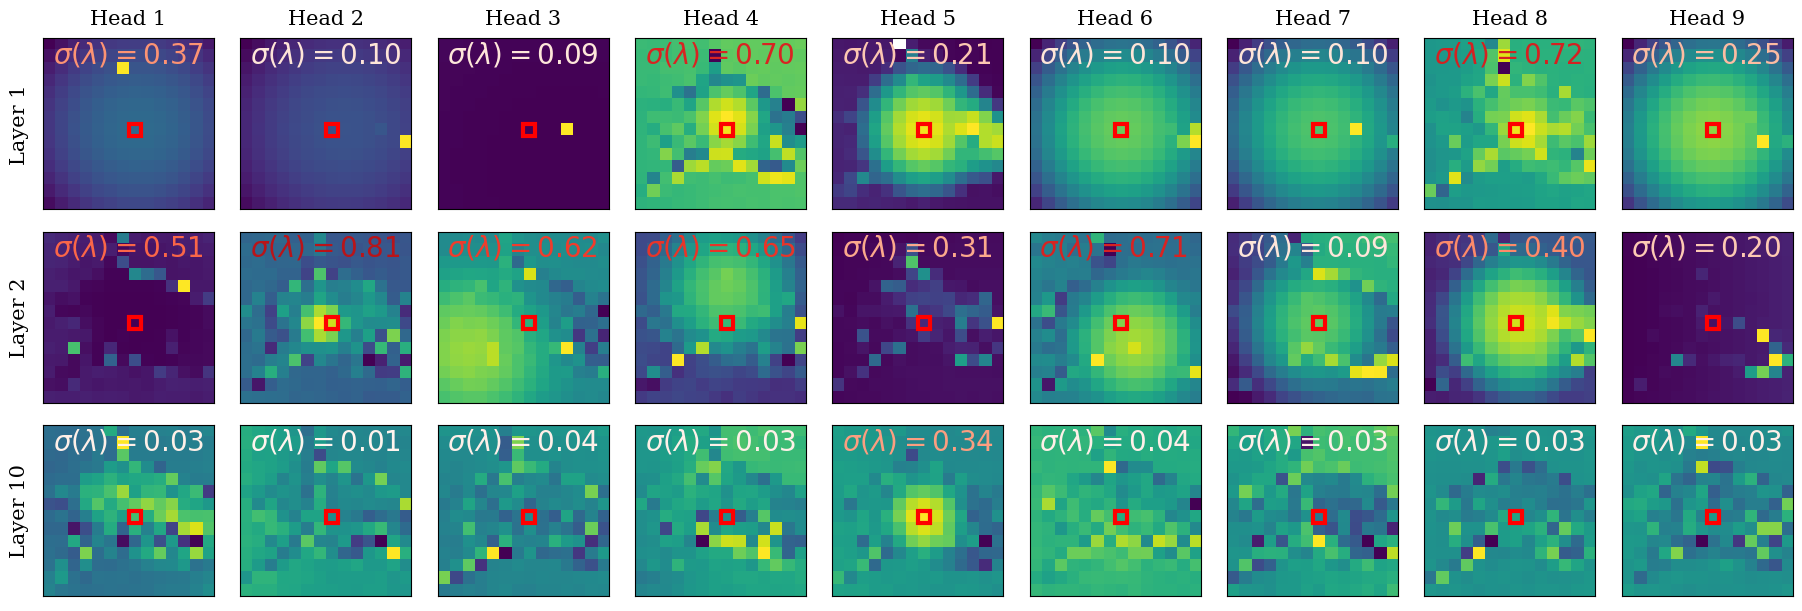

In [1365]:
x = torch.stack([dataset[101+i][0] for i in range(1)])
#x = torch.stack([dataset[i][0] for i in range(1000)])
x = x.to('cuda')

for i, local_up_to in enumerate([0, 10]):
    plt.figure()
    model = model = create_model('deit_small_patch16_224', local_up_to_layer=local_up_to, locality_dim=10)
    run = runs[i]
    state_dict_old = torch.load(runs[i]['args'].output_dir+'checkpoint.pth'.format(t))['model']
    state_dict = collections.OrderedDict()
    for k in state_dict_old:
        state_dict[k.lstrip('module.')] = state_dict_old[k]
    model.load_state_dict(state_dict)
    model = model.to('cuda')

    title = 'attention_map_dist_final_{}_{}_{}.pdf'.format(('local' if model.local_up_to_layer else 'nonlocal'),args.model.split('_')[1],args.data_set)
    plot_attention(model,x,layers=[0,1,9],save=True, title=title)

# CIFAR100 perfs
https://arxiv.org/pdf/2011.14660v2.pdf

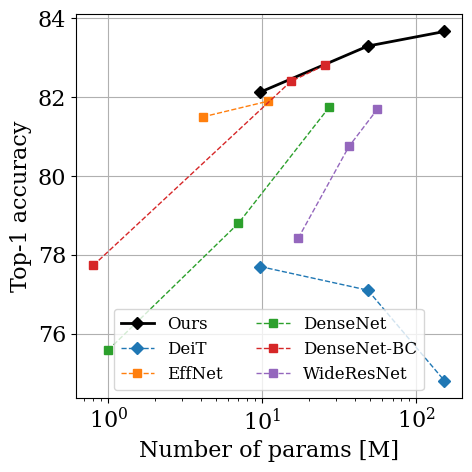

In [665]:
results = {'ConViT':[[9.7,48.4,152.1],
                    [82.13, 83.3,83.67]],
           'DeiT':([[9.7,48.4,152.1],
                   [77.7,77.1,74.8]]),
           'EffNet':[[4.1,10.9],
                     [81.5,81.9]], #https://arxiv.org/pdf/2011.14660v2.pdf
           'DenseNet':([1, 7, 27.2],
                       [75.58,78.8,81.75]),   #https://arxiv.org/pdf/1608.06993v5.pdf
           'DenseNet-BC':([[.8,15.3,25.6],
                          [77.73,82.4,82.82]]),
           'WideResNet':([17.1, 36.5,55.9],
                         [78.42,80.75,81.7]),  #https://arxiv.org/abs/1605.07146
#           'PyrNet (SOTA)':[[26.8],
#                        [88.98]]
#           'WRN-RA':([2, 36.5],
#                         [78.3, 83.3]),  #https://arxiv.org/pdf/1909.13719.pdf
#           'MobileNet':([0.5, 1.3, 2.6, 4.2],
#                        [67.5,70.8,72.2,73.4]),#https://arxiv.org/pdf/2003.13549v3.pdf
          }

plt.figure(figsize=(5,5))
for model, perfs in results.items():
    if model=='ConViT':
        plt.plot(perfs[0], perfs[1], ls='-', marker='D', lw=2, label='Ours', color='k')        
    elif 'T' in model:
        plt.plot(perfs[0], perfs[1], ls='--', marker='D', lw=1, label=model)
    else:
        plt.plot(perfs[0], perfs[1], ls='--', marker='s', lw=1, label=model)
plt.legend(fontsize=12, ncol=2)
plt.xscale('log')
plt.xlabel('Number of params [M]')
plt.ylabel('Top-1 accuracy')
plt.tight_layout()
plt.savefig(savedir+'model_size_CIFAR100_intro.pdf')
plt.show()

# ImageNet perfs

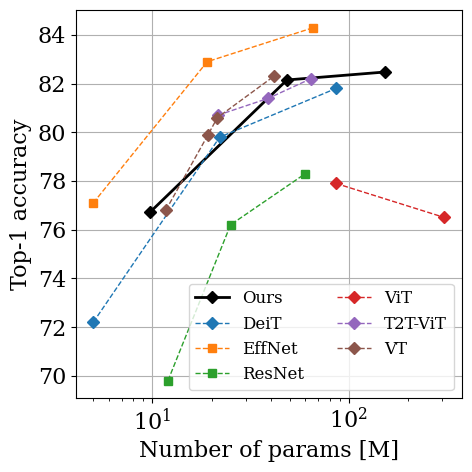

In [664]:
results = {'ConViT':([9.7,48.4,152.1],
                    [76.71000215820312,82.1500026953125,82.47600242919921]),
           'DeiT':([[5,22,86],
                   [72.2,79.8,81.8]]),
           'EffNet':[[5,19,66],
                    [77.1,82.9,84.3]],
           'ResNet':([12,25,60],
                    [69.8,76.2,78.3]),
#           'RegNet':[[21,39,84],
#                    [80,81.1,82.9]],
           'ViT':[[86,307],
                 [77.9,76.5]],
           'T2T-ViT':[[21.5,39,64],
                     [80.7,81.4,82.2]],
           'VT':[[11.7,19.2,21.4,41.5],
                [76.8,79.9,80.6,82.3]]
          }

plt.figure(figsize=(5,5))
for model, perfs in results.items():
    if model=='ConViT':
        plt.plot(perfs[0], perfs[1], ls='-', marker='D', lw=2, label='Ours', color='k')        
    elif 'T' in model:
        plt.plot(perfs[0], perfs[1], ls='--', marker='D', lw=1, label=model)
    else:
        plt.plot(perfs[0], perfs[1], ls='--', marker='s', lw=1, label=model)
plt.legend(fontsize=12, ncol=2)
plt.xscale('log')
plt.xlabel('Number of params [M]')
plt.ylabel('Top-1 accuracy')
plt.tight_layout()
plt.savefig(savedir+'model_size_IMNET_intro.pdf')
plt.show()

# FGSM

In [39]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    #perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

def test_adv( model, device, test_loader, epsilon, num_images=1000 ):

    # Accuracy counter
    correct = 0

    # Loop over all examples in test set
    for i, (data, target) in enumerate(test_loader):
        
        if i==num_images:
            break
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True
        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue
        # Calculate the loss
        loss = F.nll_loss(output, target)
        # Zero all existing gradients
        model.zero_grad()
        # Calculate gradients of model in backward pass
        loss.backward()
        # Collect datagrad
        data_grad = data.grad.data
        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        # Re-classify the perturbed image
        output = model(perturbed_data)
        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(num_images)
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, num_images, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc

In [ ]:
accuracies = {0:[], 10:[]}

for local_up_to in [0,10]:
    cons = {'model': 'deit_base_patch16_224',
            'local_up_to_layer' : local_up_to,
           }

    selected_runs, _ = select_runs(runs, params, cons)
    run = selected_runs[0]
    args = run['args']
    model = create_model(args.model, 
                         num_classes=args.nb_classes,
                         local_up_to_layer=args.local_up_to_layer, 
                         locality_dim=args.locality_dim)
    model.to('cuda')
    state_dict = torch.load(str(args.output_dir/'checkpoint.pth'))["model"]
    model.load_state_dict(state_dict)

    args = run['args']
    dataset, _ = build_dataset(is_train=False, args=args)
    data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=1, shuffle=True)

    # Run test for each epsilon
    epsilons = [0,0.02,0.04,0.06,0.08,0.1]
    for eps in epsilons:
        acc = test_adv(model, 'cuda', data_loader, eps, num_images=100)
        accuracies[local_up_to].append(acc)


/private/home/sdascoli/.conda/envs/bert/lib/python3.7/site-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Epsilon: 0	Test Accuracy = 74 / 100 = 0.74
Epsilon: 0.02	Test Accuracy = 47 / 100 = 0.47
Epsilon: 0.04	Test Accuracy = 49 / 100 = 0.49
Epsilon: 0.06	Test Accuracy = 49 / 100 = 0.49
Epsilon: 0.08	Test Accuracy = 39 / 100 = 0.39
Epsilon: 0.1	Test Accuracy = 42 / 100 = 0.42
Epsilon: 0	Test Accuracy = 82 / 100 = 0.82
Epsilon: 0.02	Test Accuracy = 50 / 100 = 0.5
Epsilon: 0.04	Test Accuracy = 44 / 100 = 0.44
Epsilon: 0.06	Test Accuracy = 40 / 100 = 0.4
Epsilon: 0.08	Test Accuracy = 51 / 100 = 0.51


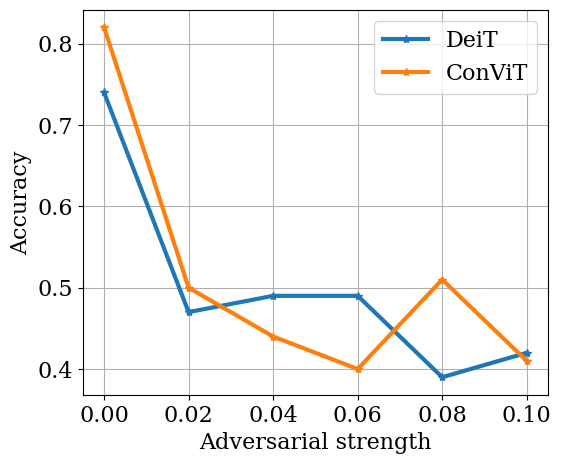

In [44]:
plt.figure(figsize=(6,5))
plt.plot(epsilons, accuracies[0], "*-", label='DeiT')
plt.plot(epsilons, accuracies[10], "*-", label='ConViT')
plt.legend()
plt.xlabel("Adversarial strength")
plt.ylabel("Accuracy")
plt.savefig(savedir+'adversarial_{}_{}.pdf'.format(args.model.split('_')[1],args.data_set))
plt.show()

79.75400235107422


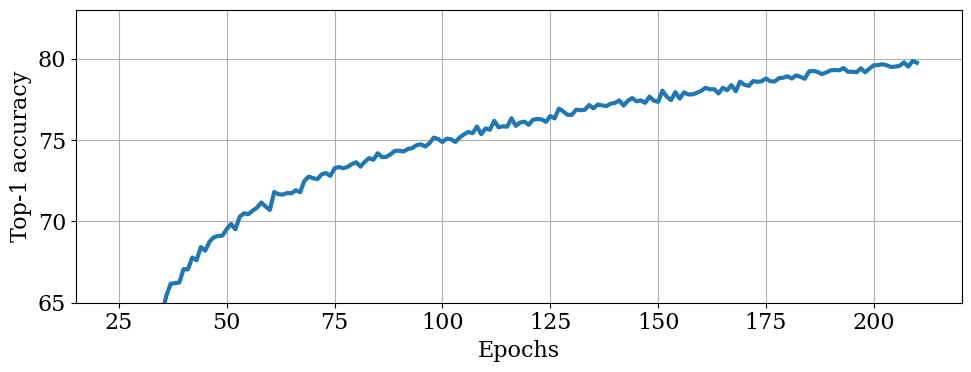

In [670]:
latest = min([len(run['logs']) for run in runs])
topk=1

fig, ax = plt.subplots(1,figsize=(10,4))
scores = {}
for run in runs:
    args = run['args']
    latest_run = len(run['logs'])
    print(run['logs'][latest_run-1]['test_acc1'])
    x = np.array(range(0, latest_run,1))
    y = [run['logs'][k]['test_acc%d'%topk] for k in x]
    ax.plot(x+1, y, label=label)  
    

ax.set_xlabel('Epochs')
ax.set_ylabel('Top-{} accuracy'.format(topk,latest))
ax.set_xlim(left=15)
ax.set_ylim(bottom=65, top=83)
#ax2.set_xlim(left=0, right=15)
#ax2.set_ylim(bottom=0, top=60)

plt.tight_layout()
plt.savefig(savedir+'ablation.pdf')
plt.show()